<a href="https://colab.research.google.com/github/tabaraei/aspect-based-sentiment-analysis/blob/main/ABSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Born and explanations provided to understand why the opinion is positive or negative, and at the end compare it with pre-trained model.

[Born Classifier](https://bornrule.eguidotti.com) is a text classification algorithm inspired by the notion of superposition of states in quantum
physics. Born provides good classification performance, explainability, and computational efficiency. In this
project, the goal is to exploit the Born explanation in order to use it for Aspect Based Sentiment Analysis. In
particular, the main idea to to proceed as follows:
1. Perform a sentiment analysis classification of documents using Born
2. Extract the explanation features for each pair of documents and predicted labels
3. Analyze the explanatory features in order to group them in candidate aspects
4. Associate each aspect to a specific sentence or portion of the text
5. Predict the sentiment for the sentence or text portion using the trained Born classifier
6. Associate then a (potentially different) sentiment to each sentence or text portion according to the aspect
7. Finally, evaluate the quality of the results for each aspect.

## Libraries and Modules

In [1]:
%%capture
!pip install datasets
!pip install bornrule

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from bornrule import BornClassifier

warnings.filterwarnings('ignore')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

In [ ]:
def visualize_confusion_matrix(cm, pred_labels, true_labels):
    plt.figure(figsize=(8, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=pred_labels, yticklabels=true_labels)
    ax.set(xlabel='Predicted Labels', ylabel='True Labels', title='Confusion Matrix')

def visualize_aspect_detection_evaluation(metrics_df):
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=metrics_df, x='Threshold', y='Value', hue='Metric', marker='o', palette='Set2')
    ax.set_ylim(0, 1)
    ax.set(xlabel='Threshold', ylabel='Metric Value', title='Evaluation Metrics vs Thresholds')

## Dataset

Any dataset supporting ABSA. See for example [here](https://paperswithcode.com/datasets?task=aspect-based-sentiment-analysis&page=1).

In [2]:
def compute_overall_sentiment(aspect_sentiments):
    pos_count = aspect_sentiments.count('positive')
    neg_count = aspect_sentiments.count('negative')

    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

def create_dataset(dataset):
    data = []
    for entry in dataset:
        document = entry['text']
        aspects = [aspect['term'] for aspect in entry['aspectTerms']]
        aspect_sentiments = [aspect['polarity'] for aspect in entry['aspectTerms']]
        overall_sentiment = compute_overall_sentiment(aspect_sentiments)
        data.append({
            'document': document,
            'aspects': aspects,
            'aspect_sentiments': aspect_sentiments,
            'overall_sentiment': overall_sentiment
        })
    return pd.DataFrame(data)

In [119]:
# Load the "restaurants" or "laptops" datasets from SemEval2014 in HuggingFace
dataset = load_dataset('alexcadillon/SemEval2014Task4', 'restaurants')
train_data, test_data = dataset['train'], dataset['test']

# Transform the data
train_df = create_dataset(train_data)
test_df = create_dataset(test_data)

# Show a sample of the data
print(f'Train size: {train_data.shape}, Test size: {test_data.shape}')
train_df.head()

Train size: (3041, 4), Test size: (800, 4)


,document,aspects,aspect_sentiments,overall_sentiment
0,But the staff was so horrible to us.,[staff],[negative],negative
1,"To be completely fair, the only redeeming fact...",[food],[positive],positive
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]",positive
3,Where Gabriela personaly greets you and recomm...,[],[],neutral
4,"For those that go once and don't enjoy it, all...",[],[],neutral


In [ ]:
# Tokenization and Vectorization
vec = CountVectorizer(tokenizer=word_tokenize, lowercase=True, token_pattern=None)
X_train, y_train = vec.fit_transform(train_df['document']), train_df['overall_sentiment']
X_test, y_test = vec.transform(test_df['document']), test_df['overall_sentiment']

No stemming or lemma, since we want to keep the original token to look for the aspects in the documents.

## Sentiment Analysis using Born

### Training and Overall Evaluation

Create a sparse matrix where rows represent documents and columns represent unique tokens (words) in the vocabulary.

In [5]:
clf = BornClassifier()
clf.fit(X_train, y_train)

BornClassifier()

In [6]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.51      0.58      0.55       125
     neutral       0.72      0.57      0.63       279
    positive       0.74      0.82      0.78       396

    accuracy                           0.70       800
   macro avg       0.66      0.66      0.65       800
weighted avg       0.70      0.70      0.69       800



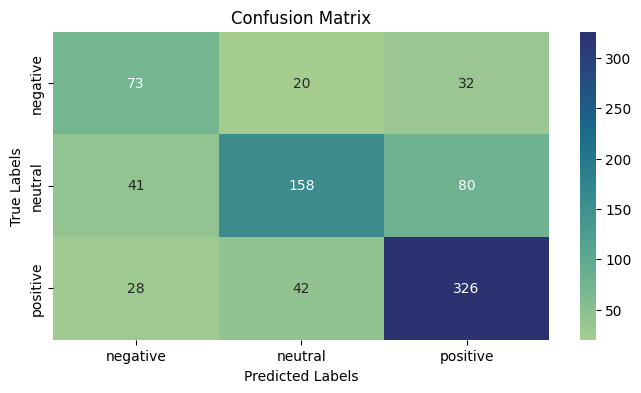

In [90]:
class_labels = sorted(train_df['overall_sentiment'].unique())
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

visualize_confusion_matrix(cm, pred_labels=class_labels, true_labels=class_labels)

### Sample Test Prediction

In [8]:
document_id = 0
test_df.iloc[document_id]

,0
document,The bread is top notch as well.
aspects,[bread]
aspect_sentiments,[positive]
overall_sentiment,positive


In [150]:
document = test_df.iloc[document_id]['document']
vectorized_doc = vec.transform([document])
pd.DataFrame(clf.predict_proba(vectorized_doc), columns=class_labels, index=['probability'])

,negative,neutral,positive
probability,0.270188,0.357623,0.372189


In [10]:
prediction = clf.predict(X_test[document_id])[0]
print(f'Predicted Sentiment: {prediction}')

Predicted Sentiment: positive


### Global Explanatory Features

In [ ]:
features = vec.get_feature_names_out()
explain = pd.DataFrame(clf.explain().toarray(), index=features, columns=class_labels)

In [ ]:
explain['positive'].sort_values(ascending=False).head()

In [ ]:
explain['negative'].sort_values(ascending=False).head()

## Aspect Detection

In [134]:
class AspectDetection:
    def __init__(self, clf, vec, train_df, X_train):
        self.clf = clf
        self.vec = vec
        self.train_df = train_df
        self.X_train = X_train

    def is_noun(self, word):
        pos = pos_tag(word_tokenize(word))[0][1]
        return pos in ['NN', 'NNS', 'NNP', 'NNPS']

    def get_candidates(self, clf, vectorized_doc, threshold_aspect=0.004):
        '''
        For a given vectoried document, first we compute its overall sentiment, based
        on which we retrieve the corresponding explanatory features. Then, we keep the
        non-zero features (controlled by threshold) and sort them in descending
        order as candidates.
        '''
        features = vec.get_feature_names_out()
        prediction = clf.predict(vectorized_doc)[0]
        local_explain = pd.DataFrame(clf.explain(vectorized_doc).toarray(), index=features, columns=class_labels)
        candidates = local_explain[prediction][local_explain[prediction] > threshold_aspect]

        candidate_aspects = candidates[candidates.index.to_series().apply(self.is_noun)]
        return candidate_aspects.index.tolist()

    def shorten_aspect_tokens(self, set1, set2):
        '''
        This function aims to match the tokens in set1 with the tokens in set2 in cases
        that the string in one set is substring in another. For example, when dealing
        with evaluation of aspects such as "battery life", it could be seen equivalent
        to "battery" or "battery life expectancy" for a more accurate evaluation.
        '''
        set1_reduced = set()
        for t in set1:
            match_found = False
            for c in set2:
                if t in c:
                    set1_reduced.add(t)
                    match_found = True
                    break
                elif c in t:
                    set1_reduced.add(c)
                    match_found = True
                    break
            if not match_found:
                set1_reduced.add(t)
        return set1_reduced

    def evaluate_aspect_detection(self, threshold_aspect):
        '''
        True Positive (TP): Elements in both candidate_set and true_set.
        False Positive (FP): Elements in candidate_set but not in true_set.
        False Negative (FN): Elements in true_set but not in candidate_set.
        True Negative (TN): Rewarded when both sets are empty
        '''
        TP, FP, TN, FN = 0, 0, 0, 0
        true_aspects = self.train_df['aspects'].tolist()
        candidate_aspects = [self.get_candidates(self.clf, vectorized_doc=self.X_train[idx], threshold_aspect=threshold_aspect)
                            for idx in self.train_df.index]

        for candidate_aspect, true_aspect in zip(candidate_aspects, true_aspects):
            candidate_aspect = self.shorten_aspect_tokens(set(candidate_aspect), set(true_aspect))
            true_aspect = self.shorten_aspect_tokens(set(true_aspect), set(candidate_aspect))

            TP += len(candidate_aspect & true_aspect)
            FP += len(candidate_aspect - true_aspect)
            FN += len(true_aspect - candidate_aspect)
            TN += 1 if not candidate_aspect and not true_aspect else 0

        confusion_matrix = pd.DataFrame(np.array([[TP, FN],[FP, TN]]),
            index=['Aspect', 'Non-Aspect'],
            columns=['Aspect', 'Non-Aspect'])

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        evaluation_metrics = {'confusion_matrix': confusion_matrix, 'accuracy': accuracy,
                              'precision': precision, 'recall': recall, 'f1': f1}
        return evaluation_metrics


    def optimize_threshold_aspect(self):
        pass

    def get_sentence_for_aspect(self, document, aspects):
        sentences = pd.Series(sent_tokenize(document))
        return [{aspect: sentences[sentences.str.contains(aspect)].iloc[0]} for aspect in aspects]


AD = AspectDetection(clf, vec, train_df, X_train)

### Shorten Candidate/True Aspect Tokens

In [83]:
candidate_aspect = {'noodles', 'bread with olive oil', 'tomato'}
true_aspect = {'noodles soup', 'bread', 'eggs'}
candidate_aspect = AD.reduce_aspect_tokens(candidate_aspect, true_aspect)
true_aspect = AD.reduce_aspect_tokens(true_aspect, candidate_aspect)

print(f'Candidate Aspects: {candidate_aspect}')
print(f'True Aspects: {true_aspect}')

Candidate Aspects: {'tomato', 'noodles', 'bread'}
True Aspects: {'noodles', 'eggs', 'bread'}


### Optimize Aspect Detection Threshold

In [132]:
evaluation_metrics_list = list()
aspect_thresholds = np.linspace(0.001, 0.01, 3)
best_aspect_threshold = None
best_f1_score = 0

for aspect_threshold in aspect_thresholds:
    evaluation_metrics = AD.evaluate_aspect_detection(aspect_threshold)
    del evaluation_metrics['confusion_matrix']
    if evaluation_metrics['f1'] > best_f1_score:
        best_f1_score = evaluation_metrics['f1']
        best_aspect_threshold = aspect_threshold
    evaluation_metrics_list.append(evaluation_metrics)

print(f'Best Aspect Threshold: {best_aspect_threshold}')
print(f'F1-Score: {best_f1_score}')

Best Aspect Threshold: 0.001
F1-Score: 0.42456326098464797


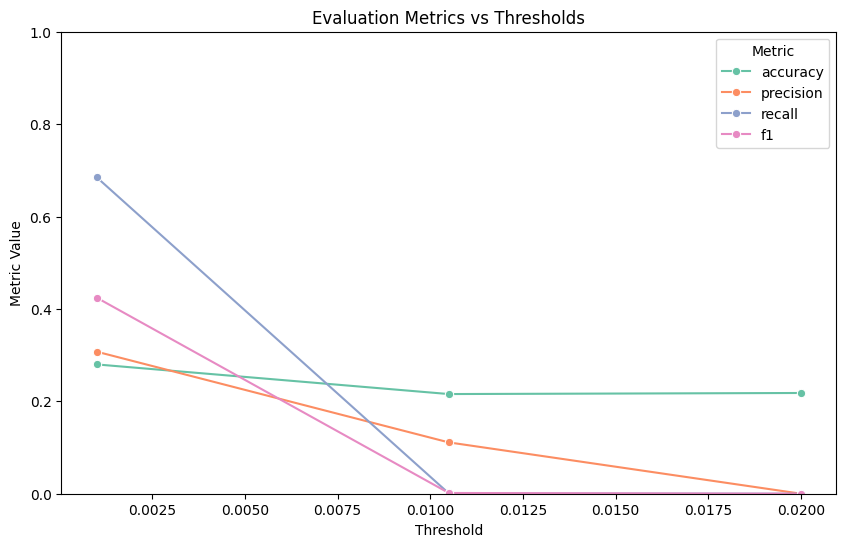

In [133]:
metrics_df = pd.DataFrame(evaluation_metrics_list)
metrics_df['Threshold'] = aspect_thresholds
metrics_df = metrics_df.melt(id_vars='Threshold', var_name='Metric', value_name='Value')

visualize_aspect_detection_evaluation(metrics_df)

### Overall Aspect Detection Evaluation

In [140]:
evaluation_metrics = AD.evaluate_aspect_detection(best_aspect_threshold)
cm = evaluation_metrics['confusion_matrix']
del evaluation_metrics['confusion_matrix']
pd.DataFrame([evaluation_metrics], index=['value'])

,accuracy,precision,recall,f1
value,0.279894,0.307555,0.685275,0.424563


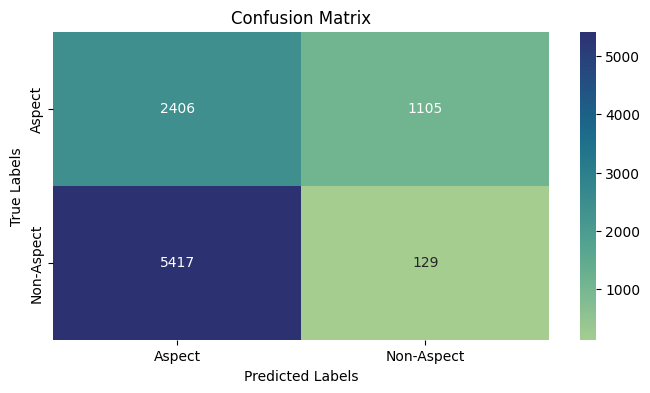

In [142]:
visualize_confusion_matrix(cm, pred_labels=cm.columns, true_labels=cm.index)

In [99]:
# true_aspects = train_df['aspects'].tolist()
# candidate_aspects = [AD.get_candidates(clf, vectorized_doc=X_train[idx]) for idx in train_df.index]
# for i in range(len(candidate_aspects)):
#     print(i, candidate_aspects[i], true_aspects[i])

## Association of Aspects to Text

In [143]:
document_id = 3
document = test_df.loc[document_id, 'document']
test_df.iloc[document_id]

,3
document,Did I mention that the coffee is OUTSTANDING?
aspects,[coffee]
aspect_sentiments,[positive]
overall_sentiment,positive


In [148]:
vectorized_doc = X_test[document_id]
candidate_aspects = AD.get_candidates(clf, vectorized_doc, best_aspect_threshold)
candidate_aspects

['coffee', 'i']

In [149]:
aspect_sentence_pairs = AD.get_sentence_for_aspect(document, candidate_aspects)
for idx, pair in enumerate(aspect_sentence_pairs):
    for aspect, sentence in pair.items():
        prediction = clf.predict(vec.transform([sentence]))[0]
        print(f'Sentence: {sentence}\nAspect: {aspect}\nPrediction: {prediction}')
        if idx != len(aspect_sentence_pairs) - 1: print('-' * 80)

Sentence: Did I mention that the coffee is OUTSTANDING?
Aspect: coffee
Prediction: positive
--------------------------------------------------------------------------------
Sentence: Did I mention that the coffee is OUTSTANDING?
Aspect: i
Prediction: positive


## TODO

In [ ]:
# fix POS (use spaCy)
# try bigrams + mutual info

## NLTK

In [ ]:
sample_text = "I love this product! It's amazing."

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

_ = nltk.download('vader_lexicon', quiet=True)
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_analyzer.polarity_scores(sample_text)

{'neg': 0.0, 'neu': 0.266, 'pos': 0.734, 'compound': 0.8516}

## RoBERTa

In [ ]:
sample_text = "I love this product! It's amazing."

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
encoded_text = tokenizer(sample_text, return_tensors='pt')
output = model(**encoded_text)[0][0]
scores = softmax(output.detach().numpy())
neg, neu, pos = scores
scores

array([0.00212159, 0.00545376, 0.9924246 ], dtype=float32)

## References

- Emanuele Guidotti and Alfio Ferrara. Text Classification with Born’s Rule. Advances in Neural Information
Processing Systems, 2022.
- Schouten, K., & Frasincar, F. (2015). Survey on aspect-level sentiment analysis. IEEE Transactions on
Knowledge and Data Engineering, 28(3), 813-830. [link](https://ieeexplore.ieee.org/document/7286808)
- Rana, T. A., & Cheah, Y. N. (2016). Aspect extraction in sentiment analysis: comparative analysis and survey.
Artificial Intelligence Review, 46(4), 459-483. [link](https://link.springer.com/article/10.1007/s10462-016-9472-z)